<a href="https://colab.research.google.com/github/Tnecniv-Teikram/SAR_ship_detection/blob/main/space_academy_SAR_ship_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0- Set up Google Colab
Google Colab provides a free GPU environment that allows you to train AI models like YOLO.

## A) Open Google Colab and Enable GPU
1. Go to Google Colab.
2. Click on File → Upload Notebook
3. Enable GPU:
    - Click on Runtime → Change runtime type
    - Set Hardware accelerator to GPU
    - Click Save

## B) Install YOLOv8 via Ultralytics

In [ ]:
!pip install ultralytics rasterio

## C) Imports

In [ ]:
# import ultralytics
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import shutil
import random
import os
import yaml

import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from IPython.display import Image as IPyImage

import rasterio
from rasterio.windows import Window
from rasterio.transform import xy
import torch
import json
from shapely.geometry import Polygon, mapping

from PIL import Image

#Some Helper functions

def read_labels_bb(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    bboxes = []
    for obj in root.findall('.//object'):
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        bboxes.append((xmin, ymin, xmax, ymax))

    return bboxes

def read_labels_obb(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    bboxes = []
    for obj in root.findall('.//object'):
        rotated_bbox = obj.find('rotated_bndbox')

        # Extract the coordinates and rotation angle
        cx = float(rotated_bbox.find('rotated_bbox_cx').text)
        cy = float(rotated_bbox.find('rotated_bbox_cy').text)
        w = float(rotated_bbox.find('rotated_bbox_w').text)
        h = float(rotated_bbox.find('rotated_bbox_h').text)
        theta = float(rotated_bbox.find('rotated_bbox_theta').text)

        # Extract corner points
        corners = []
        for i in range(1, 5):
            x = float(rotated_bbox.find(f'x{i}').text)
            y = float(rotated_bbox.find(f'y{i}').text)
            corners.append((x, y))

        bboxes.append({'center': (cx, cy), 'width': w, 'height': h, 'theta': theta, 'corners': corners})

    return bboxes

def read_labels_poly(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    polygons = []
    for obj in root.findall('.//object'):
        segm = obj.find('segm')  # Look for segmentation (polygon) data
        if segm is not None:
            points = []
            for point in segm.findall('point'):
                x, y = map(int, point.text.split(','))
                points.append((x, y))
            polygons.append(points)

    return polygons

def display_sample_images(images, names, labels = None, bbox_color='r', label_type = "bb"):
    """
    Display 6 images on a 2x3 plot grid.
    Modify the function to display more or less images.
    If labels are to be added, the list should match the list of images
    """

    # Display images
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle("Sample SAR Images from SSDD", fontsize=16)

    for i, ax in enumerate(axes.flat):
        image = cv2.imread(images[i])

        ax.imshow(image, cmap='gray')
        ax.set_title(f"{names[i]}")
        ax.axis("off")

        #display label
        if labels is not None:

            if label_type == "bb":
                #read abels
                bboxes = read_labels_bb(labels[i])

                #display labels
                for bbox in bboxes:
                    xmin, ymin, xmax, ymax = bbox
                    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=bbox_color, facecolor='none')
                    ax.add_patch(rect)

            elif label_type == "obb":
                #read abels
                bboxes = read_labels_obb(labels[i])

                #display labels
                for bbox in bboxes:
                    # Unpack bounding box data
                    corners = np.array(bbox['corners'])
                    # Create a polygon for the rotated bounding box
                    polygon = patches.Polygon(corners, linewidth=2, edgecolor=bbox_color, facecolor='none')
                    ax.add_patch(polygon)

            elif label_type == "poly":
                #read abels
                polygons = read_labels_poly(labels[i])

                #display labels
                for polygon in polygons:
                    polygon = np.array(polygon)
                    polygon_patch = patches.Polygon(polygon, linewidth=2, edgecolor=bbox_color, facecolor='none')
                    ax.add_patch(polygon_patch)

    plt.tight_layout()
    plt.show()



## D) Mount Google Drive in Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

HOME = '/content/drive/MyDrive/space_academy'
# HOME = '/Users/emmanuel.fall/Documents/gIX/AI_model/ship_detection/space_academy_SAR_ship_detection/'
os.chdir(HOME)

!ls -ll $HOME

total 90432
drwxr-xr-x   5 emmanuel.fall  staff       160 Mar  6 10:32 SSDD
-rw-r--r--@  1 emmanuel.fall  staff  40196505 Mar 10 11:29 SSDD.zip
drwxr-xr-x   7 emmanuel.fall  staff       224 Mar 10 09:58 dataset
drwxr-xr-x  12 emmanuel.fall  staff       384 Mar  5 12:28 doc
drwxr-xr-x   3 emmanuel.fall  staff        96 Mar  6 12:01 path
-rw-r--r--@  1 emmanuel.fall  staff   5131444 Mar 10 12:12 space_academy_SAR_ship_detection.ipynb


# 1- Introduction to Dataset: SAR Ship Detection Dataset (SSDD)
   - Overview of the selected dataset (SSDD)
   - Challenges in SAR ship object detection

## A) SAR Ship Detection Dataset (SSDD) - Summary

The **SAR Ship Detection Dataset (SSDD)** is a publicly available dataset for ship detection in SAR images, used in maritime surveillance and security applications.

**Key Features**:
- **Multi-Sensor and Multi-Resolution SAR images** with labeled ship locations.
    - different resolutions from 1 m to 15 m
    - different sensors from RadarSat-2, TerraSAR-X, and Sentinel-1
    - different ship sizes
    - different sea conditions
- **Bounding box annotations** for object detection.
- **Diverse environments** including open sea, inshore, and port areas.

**Applications**:
- Maritime security and vessel tracking.
- Illegal fishing and smuggling detection.
- Environmental monitoring.

**Challenges**:
- **Speckle Noise**: Affects image clarity.
- **Class Imbalance**: Ships vary in size and frequency.
- **Complex Backgrounds**: Water conditions and clutter affect detection accuracy.

### Visualize sample images from SSDD

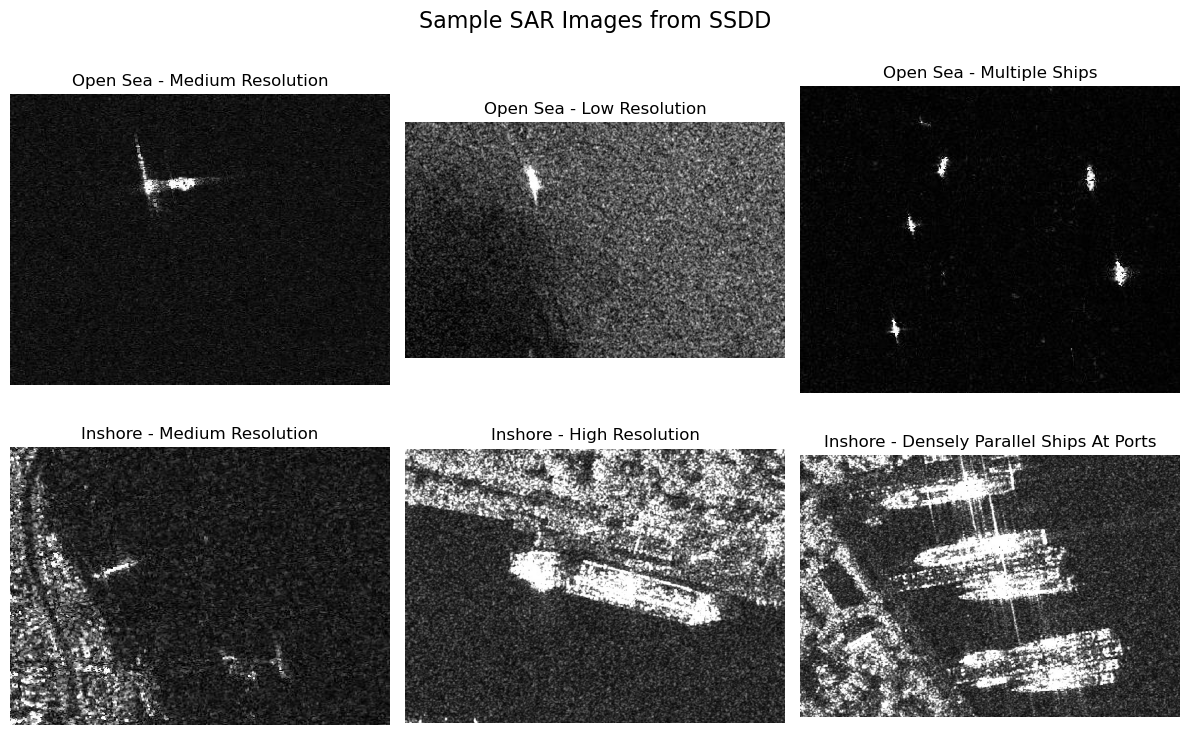

In [ ]:
# Select 6 images
dir_path = os.path.join(HOME,"doc")
image_ids = ["000009", "000841", "000089", "000249", "000221", "000219"]
image_paths = [os.path.join(dir_path, f'{image_ids[i]}.jpg') for i in range(len(image_ids))] #add directory

#Define title for each image for display
names= ["Open Sea - Medium Resolution", "Open Sea - Low Resolution", "Open Sea - Multiple Ships",
        "Inshore - Medium Resolution", "Inshore - High Resolution", "Inshore - Densely Parallel Ships At Ports"]

display_sample_images(image_paths, names)


### Labels

In object detection, different types of bounding boxes are used to annotate objects in images. These labels vary in shape and complexity, and each has its own set of advantages and disadvantages.

**1- Rectangular Bounding Boxes**:
 - Rectangular box that is aligned with the image axes
    - **Widely Supported**: Most common type of annotation, used by most machine learning models and datasets.
    - **Simplicity and Efficient**: Easy to generate and annotate, and to analyse (intersections, areas ...).
    - **Limited Precision**: Doesn't capture the object's exact shape, especially for objects that are not aligned with the axes.
    - **Wasted Space**: may enclose a lot of empty space around the object, leading to inefficiency in training data representation.

**2- Oriented Bounding Boxes**:
- Rectangular box that is rotated to fit the object more tightly
    - **Tighter Fit**: More accurately surrounds rotated or angled objects compared to axis-aligned boxes.
    - **Reduced Empty Space**: Helps in reducing the unused space within the bounding box compared to rectangular bounding boxes.
    - **Complexity**: More difficult to annotate compared to axis-aligned bounding boxes, and more complex to analyse (intersections, areas ...).
    - **Not Always Supported**: Some models or tools may not support rotated bounding boxes out of the box.

**3- Polygons**:
- Series of vertices that represent the exact outline of the object
    - **Most Precise**: Captures the exact shape of an object, making it ideal for fine-grained segmentation tasks.
    - **Flexibility**: Can annotate objects with complex or irregular shapes (e.g., curved edges or non-rectangular structures).
    - **Detailed Object Representation**: Used in semantic segmentation where pixel-level accuracy is needed.
    - **Increased Complexity**: Even more difficult to annotate, and more complex to analyse (intersections, areas ...).


#### Rectangular BB

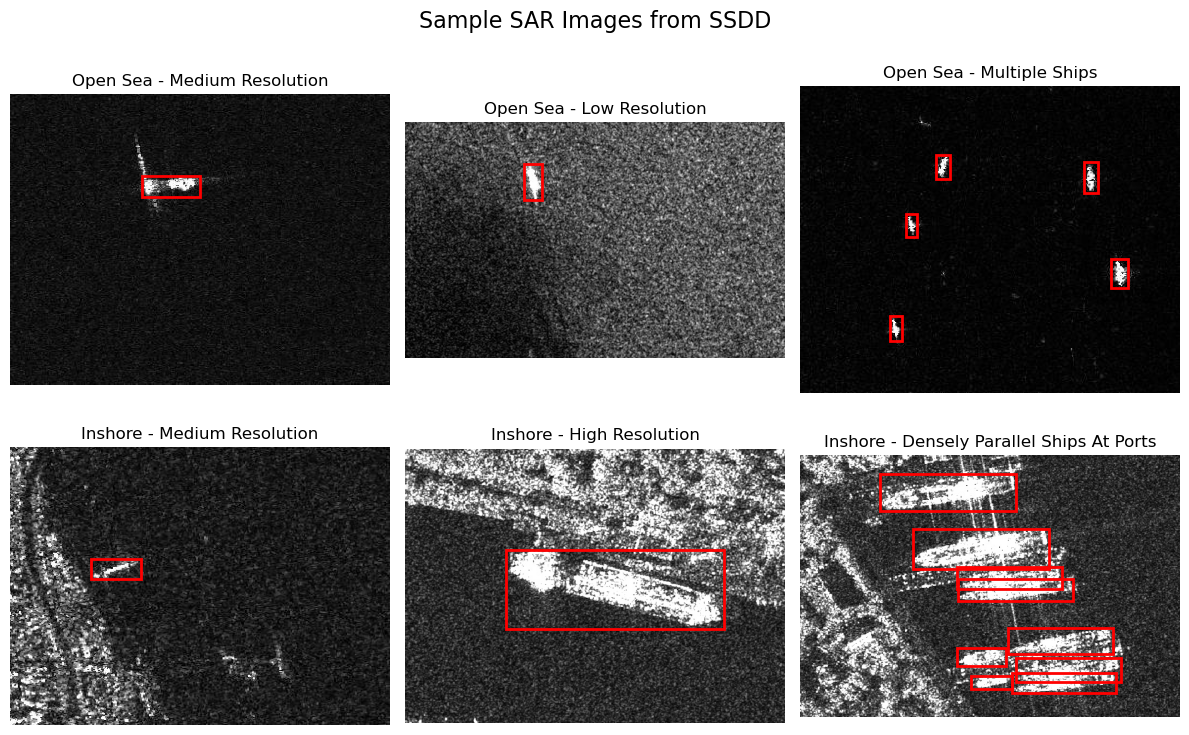

In [ ]:
dir_path = os.path.join(HOME,"doc/labels_BB")
label_paths = [os.path.join(dir_path, f'{image_ids[i]}.xml') for i in range(len(image_ids))] #add directory

display_sample_images(image_paths, names, label_paths)

#### Oriented BB

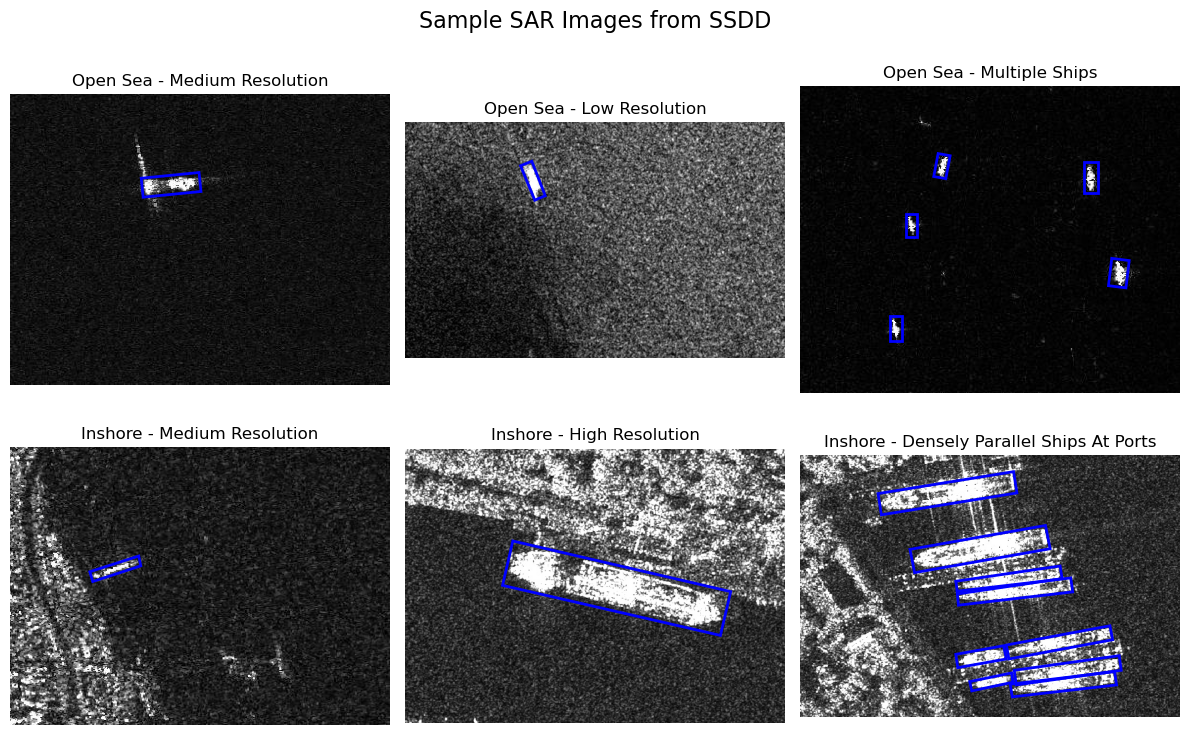

In [ ]:
dir_path = os.path.join(HOME,"doc/labels_OBB")
label_paths = [os.path.join(dir_path, f'{image_ids[i]}.xml') for i in range(len(image_ids))] #add directory

display_sample_images(image_paths, names, label_paths, label_type="obb", bbox_color='b')

#### Polygon Segmentation

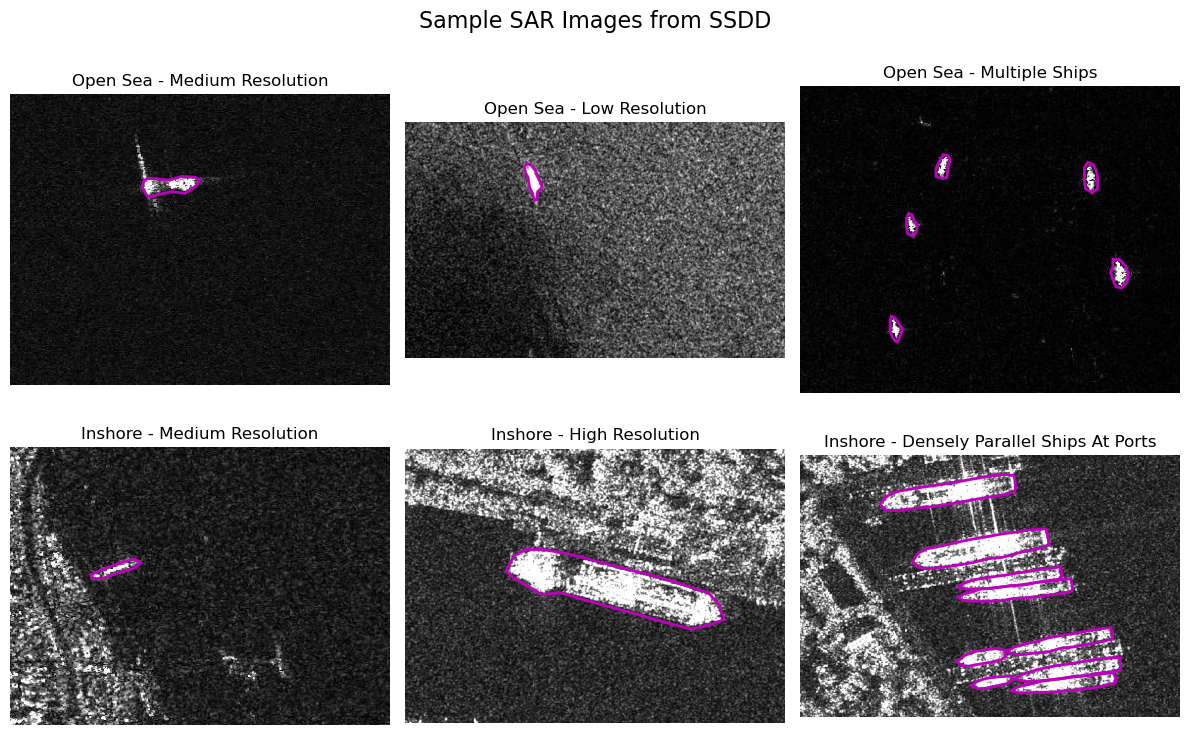

In [ ]:
dir_path = os.path.join(HOME,"doc/labels_poly")
label_paths = [os.path.join(dir_path, f'{image_ids[i]}.xml') for i in range(len(image_ids))] #add directory

display_sample_images(image_paths, names, label_paths, label_type="poly", bbox_color='m')

# 2- Dataset Preparation
    - Data preprocessing
    - Dataset split

## A) Data Preprocessing

SAR images often require a minimum level of pre-processing before analyzing it either visually or analytically.
Depending on the original products, this may include:

- **Radiometric calibration**
- **Speckle Filtering**
- **Terrain Correction**
- **Data type conversion**

Since we are using a public dataset that were already prepared, we don't have to do any of this. However, if we want to apply a model that was trained on this dataset on a new image we will have to pre-process it (c.f. section X).

## B) Dataset Splitting

Divide the dataset into:
- **Training set** (~70-80%) – Used for model learning.
- **Validation set** (~10-15%) – Used to tune hyperparameters.
- **Test set** (~10-15%) – Used for final performance evaluation.

In [ ]:
def split_dataset(image_dir, label_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Splits (randomly) a dataset into training, validation, and test sets.

    Args:
        image_dir (str): Path to the folder containing images.
        label_dir (str): Path to the folder containing annotation files.
        output_dir (str): Path to the output directory where the split datasets will be stored.
        train_ratio (float): Proportion of images for training.
        val_ratio (float): Proportion of images for validation.
        test_ratio (float): Proportion of images for testing.
        seed (int): Random seed for reproducibility.
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1"

    # Create output directories
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, 'labels'), exist_ok=True)

    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Shuffle dataset
    random.seed(seed)
    random.shuffle(image_files)

    # Split dataset
    total_images = len(image_files)
    train_split = int(total_images * train_ratio)
    val_split = train_split + int(total_images * val_ratio)

    train_files = image_files[:train_split]
    val_files = image_files[train_split:val_split]
    test_files = image_files[val_split:]

    # Helper function to copy files
    def copy_files(file_list, split):
        for file in file_list:
            # Copy image
            shutil.copy(os.path.join(image_dir, file), os.path.join(output_dir, split, 'images', file))
            # Copy annotation (assumes same filename with .xml extension)
            annotation_file = os.path.splitext(file)[0] + '.txt'
            annotation_path = os.path.join(label_dir, annotation_file)
            if os.path.exists(annotation_path):
                shutil.copy(annotation_path, os.path.join(output_dir, split, 'labels', annotation_file))

    # Copy files to respective folders
    copy_files(train_files, 'train')
    copy_files(val_files, 'val')
    copy_files(test_files, 'test')

    print(f"Dataset split completed: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

How It Works:
1. **Takes paths** for images and annotations and creates `train`, `val`, and `test` directories.
2. **Shuffles and splits** the dataset based on the given ratios.
3. **Copies images** and corresponding annotations to their respective split folders.


In [ ]:
output_dataset_dir = os.path.join(HOME,"dataset")
split_dataset(
    image_dir=os.path.join(HOME,"SSDD/images"),
    label_dir=os.path.join(HOME,"SSDD/labels"),
    output_dir=output_dataset_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)

Dataset split completed: 793 train, 170 val, 171 test


In [ ]:
!tree $output_dataset_dir -L 2

/Users/emmanuel.fall/Documents/gIX/AI_model/ship_detection/space_academy_SAR_ship_detection/dataset
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── val
    ├── images
    └── labels

10 directories, 0 files


## C) Format Data for Model Training

Convert annotations to the required format for the chosen object detection framework (YOLO, Faster R-CNN, etc.).
Ensure correct file paths and dataset structure.

**Dataset Format**
- YOLOv8 accepts oriented bounding boxes (OBB) in the format of 4 corner coordinates: `[x1, y1, x2, y2, x3, y3, x4, y4]`.
- The coordinates are normalized to the image size, i.e., values should range from 0 to 1.
- The labels are stored in a .txt file for each image, with the following structure: `class_id x1 y1 x2 y2 x3 y3 x4 y4`

**Directory Structure**

The typical directory structure for YOLOv8 OBB datasets is as follows:
```
dataset/
├── test
│   ├── images
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   └── labels
│   │   ├── image1.txt
│   │   ├── image2.txt
│   │   └── ...
├── train
│   ├── images
│   └── labels
└── val
│   ├── images
│   └── labels
└── data.yaml
```
- **images/**: Contains the images divided into train, val, and test subdirectories.
- **labels/**: Contains label files with the same name as the corresponding image file but with a .txt extension, also divided into train, val, and test.
- **data.yaml**: A YAML configuration file specifying class names and paths to the image and label directories.

Each `.txt` file in the labels/ directories contains one line per object in the corresponding image, with each line following the format: `class_id x1 y1 x2 y2 x3 y3 x4 y4`.

We already have the images and labels with the expected format and organized with the expected directory structures. We only have to generate the `data.yaml`

In [ ]:
#generate data.yaml

def create_data_yaml(dataset_path, class_names, train_relpath, val_relpath, test_relpath, output_path="data.yaml"):
    data_yaml = {
        "train": os.path.join(dataset_path, train_relpath),
        "val": os.path.join(dataset_path, val_relpath),
        "test": os.path.join(dataset_path, test_relpath),
        "nc": len(class_names),  # Number of classes
        "names": class_names      # Class names
    }

    output_path = os.path.join(dataset_path, output_path)
    with open(output_path, "w") as f:
        yaml.dump(data_yaml, f, default_flow_style=False)

    print(f"data.yaml generated at: {output_path}")

In [ ]:
dataset_path = os.path.join(HOME,"dataset")
class_names = ["ship"]
train_relpath = 'train/images'
val_relpath = 'val/images'
test_relpath = 'test/images'

create_data_yaml(dataset_path, class_names, train_relpath, val_relpath, test_relpath)

# 3- Model Selection & Training
 - Using YOLOv8 for object detection (pre-trained model)
 - Model training and evaluation


In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model (pre-trained)
model = YOLO("yolov8n-obb.pt")

results = model.train(
    data=os.path.join(HOME, "dataset", "data.yaml"),  # Path to dataset config
    epochs=20,  # Training epochs
    imgsz=640,  # Image size,
    project="YOLOv8-OBB-Training",
    name="exp1",
    batch=16,   # Batch size
    device="cuda",
)

In [ ]:
# After training, evaluate the model on the validation set:
metrics = model.val()

## Display training outputs
Google Colab provides a free GPU environment that allows you to train models like YOLO.
- Confusion Matrix
- Loss and other metrics

In [ ]:
!ls {HOME}/YOLOv8-OBB-Training/exp13/

In [ ]:
IPyImage(filename=os.path.join(HOME, "YOLOv8-OBB-Training", "exp13", "confusion_matrix.png"), width=600)

In [ ]:
IPyImage(filename=os.path.join(HOME, "YOLOv8-OBB-Training", "exp13", "results.png"), width=600)

In [ ]:
IPyImage(filename=os.path.join(HOME, "YOLOv8-OBB-Training", "exp13", "val_batch2_pred.jpg"), width=600)

# 4- Inference & Post-Processing
 - Running predictions on new SAR images
 - Performance analysis
 - Export model for deployment

In [ ]:
from ultralytics import YOLO

#load trained model (if needed)
model = YOLO(os.path.join(HOME, "YOLOv8-OBB-Training", "exp13", "weights/best.pt"))
# model = YOLO("/Users/emmanuel.fall/Downloads/best.pt")

## A) On Test Data
- Run prediction on test images
- Evaluate model accuracy

In [ ]:
test_dataset=os.path.join(HOME, "dataset", "test/images")

# Perform detection on some test images
for img in glob.glob(f'{test_dataset}/*.jpg')[:3]:
    results = model.predict(img)
    results[0].show()

In [ ]:
# Evaluate the model on the entire test set:
test_results = model.val(
    data=os.path.join(HOME, "dataset", "data.yaml"),
    split="test",
    project='YOLOv8-OBB-Test',
    name='exp1',
    save=True
    )

In [ ]:
#Display some results
IPyImage(filename=os.path.join(HOME, "YOLOv8-OBB-Test", "exp13", "val_batch2_pred.jpg"), width=600)

## B) On New image

### 1- Image Pre-processing
Take a new Sentinel-1 image and pre-process it (using gIQ) by applying the following:
- **Radiometric calibration**
- **Speckle Filtering**
- **Terrain Correction**
- **Data type conversion**

The full pre-processing can be done in one click in gIQ:

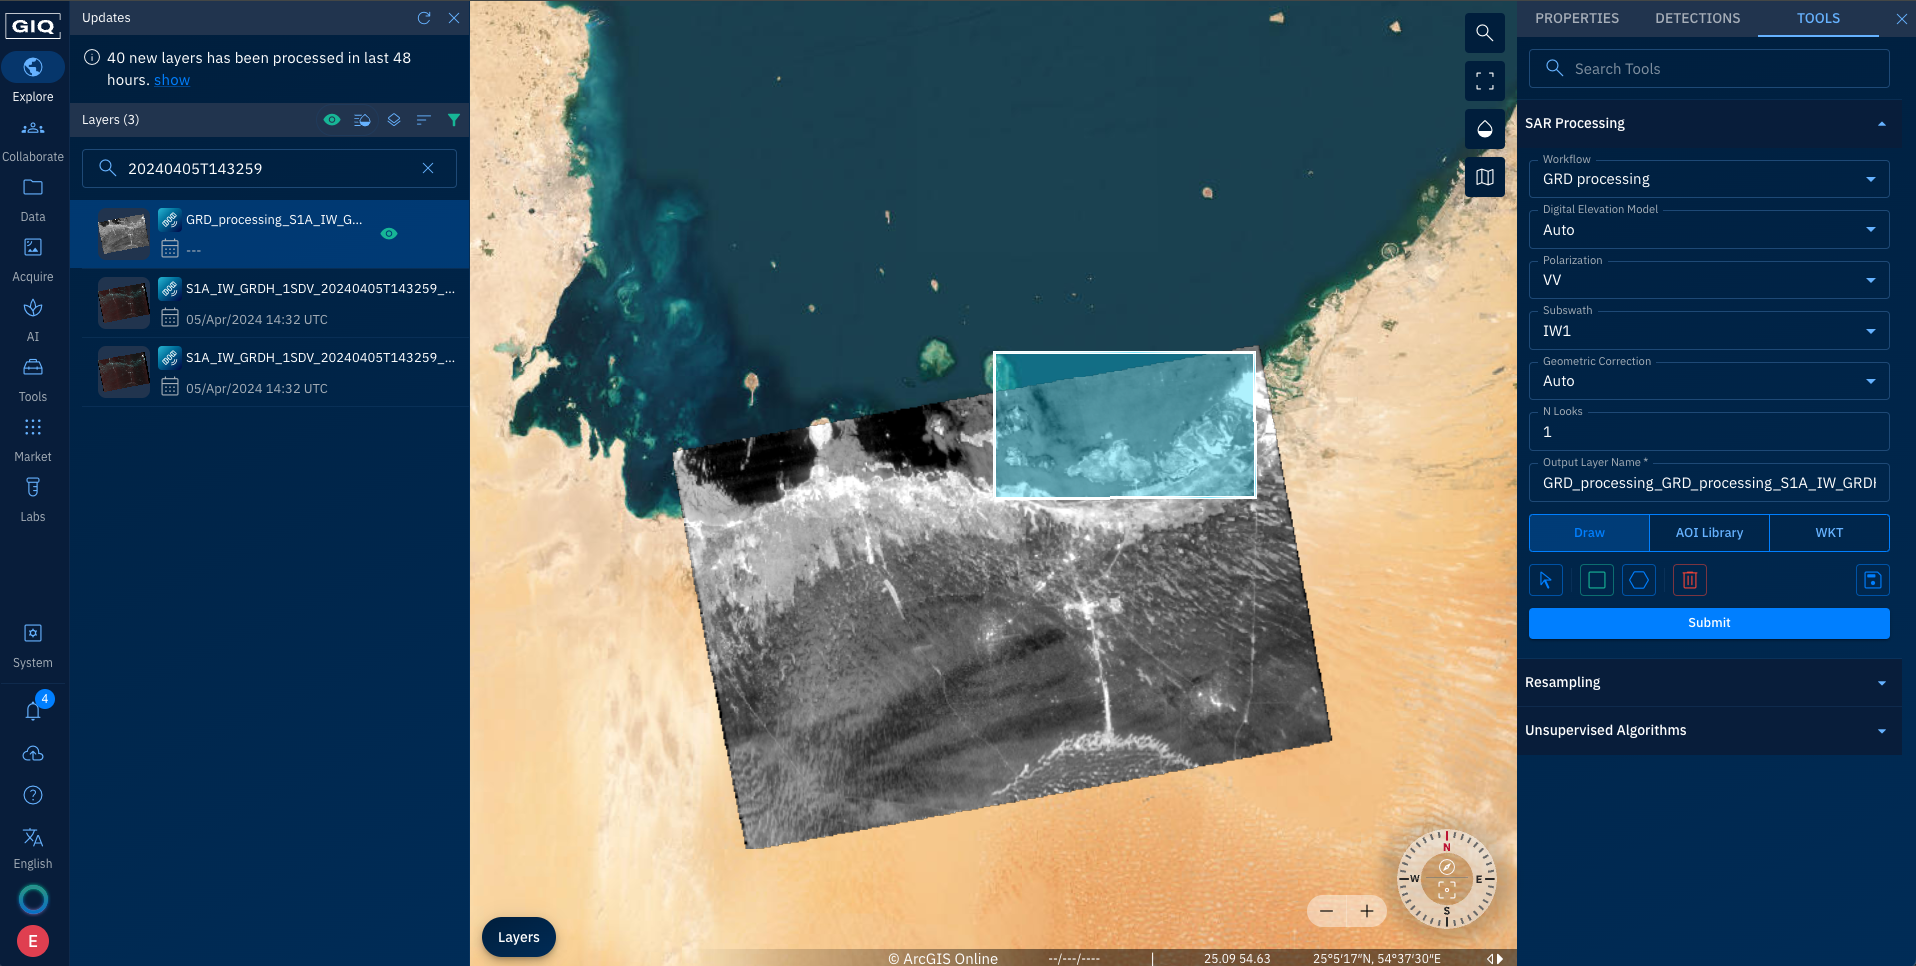

In [ ]:
IPyImage("./doc/gIQ_SAR_workflow.png", width=600)

In [ ]:
# image_path = "/Users/emmanuel.fall/Documents/Git_repos/yaml-snap-processing/output/GRD_processing/space_academy_ship_detection_S1/S1A__IW___A_20240405T143259_35175f28d2_Orb_253d7233f0_Cal_NR_Spk_EC_dB_Sigma0_VV_db.tif"
image_path = os.path.join(HOME, "S1A__IW___A_20240405T143259_35175f28d2_Orb_253d7233f0_Cal_NR_Spk_EC_dB_Sigma0_VV_db.tif")

NameError: name 'HOME' is not defined

After preprocessing the image in gIQ, the output can be used for the inference:

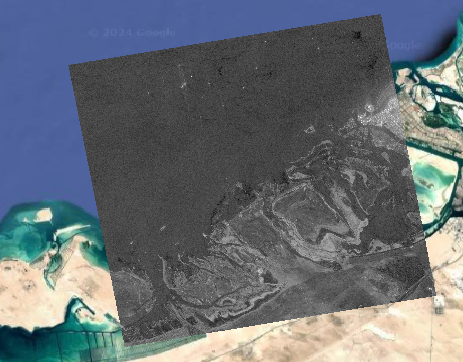

In [ ]:
IPyImage("./doc/pre_processed_image.png", width=600)

### 2- Data preparation

Then, prepare the data to be able to apply the model on it:
- **Tiling**: tile into image chips of size 640
- **RGB conversion**: convert to RGB
- **Save as PNG**: save as jpg

In [ ]:
def generate_tiles(image_path, output_dir, tile_size=640, offset_x=0, offset_y=0):
    """
    Splits a GeoTIFF into tiles and saves them as both JPEG and GeoTIFF with correct georeferencing.

    Args:
        image_path (str): Path to the input GeoTIFF image.
        output_dir (str): Path to the output directory.
        tile_size (int): Size of each tile (default: 640x640).
        offset_x (int): Starting j offset (default: 0).
        offset_y (int): Starting i offset (default: 0).
    """

    # Create subdirectories for JPEG and GeoTIFF tiles
    jpeg_dir = os.path.join(output_dir, "JPEG")
    geotiff_dir = os.path.join(output_dir, "GeoTIFF")
    os.makedirs(jpeg_dir, exist_ok=True)
    os.makedirs(geotiff_dir, exist_ok=True)


    with rasterio.open(image_path) as src:

        #get global stats
        img_array = src.read(1)  # Read first band
        img_min = img_array.min()
        img_max = img_array.max()

        for y in range(offset_y, src.height, tile_size):
            for x in range(offset_x, src.width, tile_size):
                window = Window(x, y, tile_size, tile_size)
                window_transform = src.window_transform(window)
                tile = src.read(window=window)

                #replace nan values
                mask_zero = ~np.isfinite(tile)
                tile[mask_zero] = 0

                # Normalize the image to 8-bit
                tile = (tile - img_min) / (img_max - img_min) * 255
                # tile = (tile - tile.min()) / (tile.max() - tile.min()) * 255
                tile = tile.astype(np.uint8)

                # Handle tiles that might be smaller than the tile size at the edges
                if tile.shape[0] != tile_size or tile.shape[1] != tile_size:
                    pad_width = (
                            (0, 0),
                            (0, tile_size - tile.shape[1]),
                            (0, tile_size - tile.shape[2])
                        )
                    tile = np.pad(
                        tile,
                        pad_width, #((0, tile_size - tile.shape[0]), (0, tile_size - tile.shape[1])),
                        mode='constant',
                        constant_values=0
                    )

                # Convert grayscale tile to RGB for JPEG
                if tile.shape[0] == 1:
                    tile_rgb = np.stack([tile[0]] * 3, axis=-1)  # (H, W) → (H, W, 3)

                # Save as JPEG
                tile_filename =  f"tile_{x}_{y}.jpg"
                img_pil = Image.fromarray(tile_rgb)
                img_pil.save(os.path.join(jpeg_dir, tile_filename), format="JPEG")

                # Save as GeoTIFF
                tile_tiff_filename = f"tile_{x}_{y}.tif"
                tile_tiff_path = os.path.join(geotiff_dir, tile_tiff_filename)

                # add a dim if if image has only 2 dimension
                if len(tile.shape) == 2:
                    tile = tile.reshape((1, tile.shape[0], tile.shape[1]))

                with rasterio.open(
                    tile_tiff_path,
                    "w",
                    driver="GTiff",
                    height=tile.shape[1],  # rows
                    width=tile.shape[2],  # cols
                    count=tile.shape[0],  # bands
                    dtype=tile.dtype,
                    transform=window_transform,
                    crs=src.crs,
                    compress="deflate",
                ) as dst:
                    dst.write(tile)

        print(f"Tiles saved to:\nJPEG: {jpeg_dir}\nGeoTIFF: {geotiff_dir}")

In [ ]:
# Tiling
# tile_dir = "/Users/emmanuel.fall/Documents/SAR_course/UAESA_space_academy_2025/practical/tiles"
tile_dir = os.path.join(HOME, "New_S1_image/tiles")
generate_tiles(image_path, tile_dir, offset_y=100) # the offset=100 is to fully include a ship on a specific tile


Tiles saved to:
JPEG: /Users/emmanuel.fall/Documents/SAR_course/UAESA_space_academy_2025/practical/tiles/JPEG
GeoTIFF: /Users/emmanuel.fall/Documents/SAR_course/UAESA_space_academy_2025/practical/tiles/GeoTIFF


### 3- Prediction on a single tile

Predict on one tile

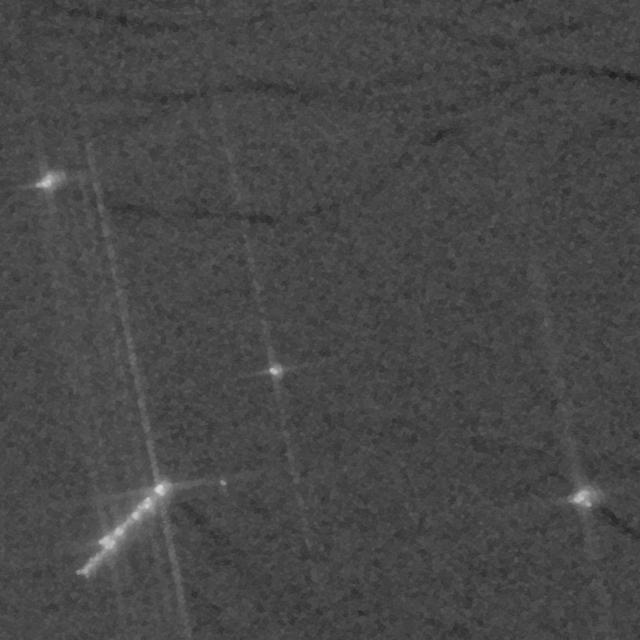

In [ ]:
#Display one tile
test_tile = os.path.join(HOME, "New_S1_image/tiles/JPEG/tile_1920_740.jpg")
IPyImage(filename=test_tile, width=600)

In [ ]:
#prediction
results = model.predict(test_tile)
# results = model.predict(test_tile, conf=0.05)
results[0].show()

: 

### 4- Prediction on all tiles

Finally, predict on all tiles and save the prediction into geojson files

In [ ]:
def save_obb_to_geojson(results, test_tile_geotif, output_geojson):
    """
    Runs YOLOv8 OBB model on a GeoTIFF and saves the oriented bounding boxes as a GeoJSON.

    Args:
    - results: The prediction result.
    - test_tile_geotif: Path to the input GeoTIFF.
    - output_geojson: Path to save the output GeoJSON.
    """
    # Load the georeferencing info from the GeoTIFF
    with rasterio.open(test_tile_geotif) as src:
        transform = src.transform  # Affine transform to convert pixel to geospatial coordinates

    # List to store GeoJSON features
    geojson_features = []

    # Loop through results
    for result in results:
        if hasattr(result, "obb") and result.obb is not None:
            obb_boxes = result.obb.xyxyxyxy  # Get OBB as corner coordinates (x1, y1, ..., x4, y4)

            if isinstance(obb_boxes, torch.Tensor):  # Convert tensor to NumPy array
                obb_boxes = obb_boxes.cpu().numpy()

            # Convert each OBB into a GeoJSON feature
            for box in obb_boxes:
                # Convert pixel coordinates to geospatial coordinates
                geo_coords = [xy(transform, y, x) for x, y in box]

                # Create a polygon and add to GeoJSON
                polygon = Polygon(geo_coords)
                feature = {
                    "type": "Feature",
                    "geometry": mapping(polygon),
                    "properties": {}  # Add any extra metadata here
                }
                geojson_features.append(feature)

    # Create GeoJSON structure
    geojson_data = {
        "type": "FeatureCollection",
        "features": geojson_features
    }

    # Save to a GeoJSON file
    with open(output_geojson, "w") as f:
        json.dump(geojson_data, f, indent=4)

    print(f"GeoJSON saved to {output_geojson}")

def merge_geojsons(input_geojson_files, output_geojson):
    """
    Merges multiple GeoJSON files into one.

    Parameters:
        input_geojson_files (list): List of input GeoJSON file paths.
        output_geojson (str): Path to save the merged GeoJSON file.
    """
    merged_features = []

    for file in input_geojson_files:
        with open(file, "r") as f:
            data = json.load(f)
            merged_features.extend(data["features"])  # Add features to list

    # Create merged GeoJSON
    merged_geojson = {
        "type": "FeatureCollection",
        "features": merged_features
    }

    # Save the merged GeoJSON
    with open(output_geojson, "w") as f:
        json.dump(merged_geojson, f, indent=4)

    print(f"\nMerged GeoJSON saved to {output_geojson}")

In [ ]:
tile_dir = os.path.join(HOME, "New_S1_image/tiles/")
prediction_dir = os.path.join(tile_dir, "predictions")
os.makedirs(prediction_dir, exist_ok=True)

for img in glob.glob(os.path.join(tile_dir, "JPEG", "*.jpg")):
    #prediction
    results = model.predict(img)

    #save prediction as geojson
    img_geotif = os.path.join(tile_dir, "GeoTIFF", f'{os.path.basename(img)[:-4]}.tif') #geotif tile to have georef info
    prediction_geojson = os.path.join(prediction_dir, f'{os.path.basename(img)[:-4]}_pred.geojson')
    save_obb_to_geojson(results, img_geotif, prediction_geojson)

#Combine geojson tiles
geojson_files = glob.glob(os.path.join(prediction_dir, "*.geojson"))
output = os.path.join(HOME, "New_S1_image/", f'{os.path.basename(image_path)[:-4]}_pred.geojson')
merge_geojsons(geojson_files, output)

### 5- Conclusion and Discussion

Prediction overlaid on input image:

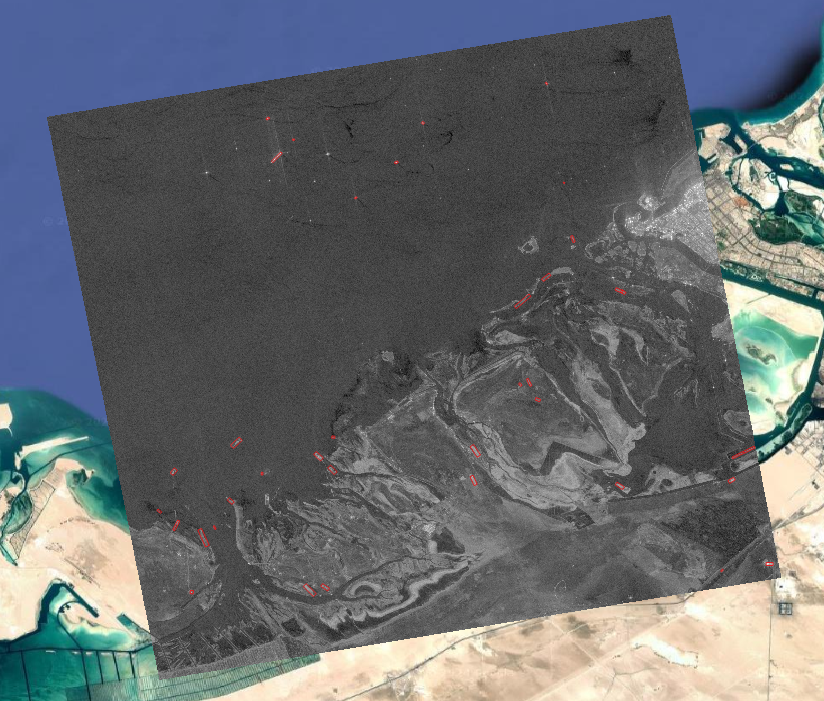

In [ ]:
IPyImage("./doc/prediction.png", width=600)

**Discussion**:
- What do you think about thes results?
- What could you do to improve results?
    - to remove False Positives?
    - to detect False Negatives?
- Do you think this model can be applied to any SAR image?
    - What are the limitations of this model?